In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


Этот датасет представляет собор данные маркетиноговой компании, где **conversion** - это целевая переменная, а **offer** - коммуникация

In [3]:
# переименуем целевую клонку и колонку коммуникации

df = df.rename(columns = {'conversion': 'target', 'offer': 'treatment'}, inplace = False)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


Приведем поле **treatment** к бинарному виду, где **No Offer** - 0, остальное 1

In [4]:
df.loc[df.treatment != "No Offer", "treatment"] = 1
df.loc[df.treatment == "No Offer", "treatment"] = 0

df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [5]:
#разделим данные на train/test
indices_learn, indices_valid = train_test_split(df.index, test_size=0.3, random_state=42)

In [6]:
features = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']

X_train = df.loc[indices_learn, features]
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_test = df.loc[indices_valid, features]
y_test = df.loc[indices_valid, 'target']
treat_test = df.loc[indices_valid, 'treatment']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

#### Обучение с одной моделью

In [7]:
# !pip install scikit-uplift==0.2.0

In [8]:
# !pip install catboost

uplift@10%: 0.1229
uplift@20%: 0.1006


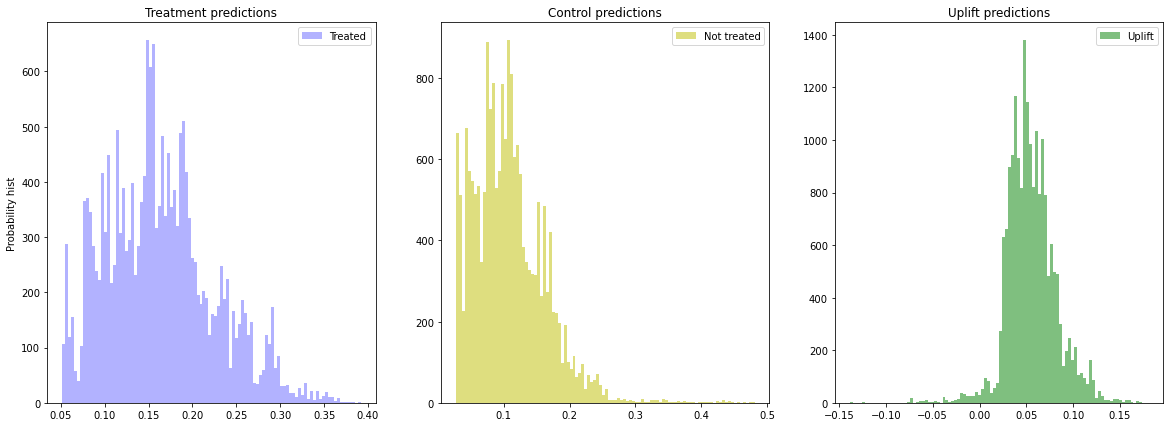

In [9]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

cat_features = ['zip_code', 'channel']


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score_10:.4f}')

sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score_20:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@10%'].append(sm_score_10)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

#### Трансформация классов

In [10]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

C:\Users\fedic\AppData\Local\Temp/ipykernel_347588/2288561425.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


#### Две независимые модели

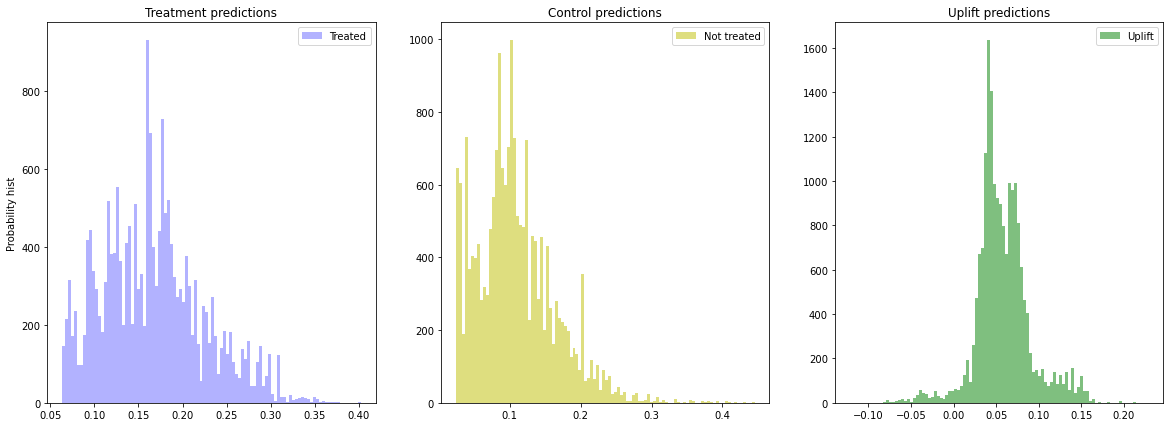

In [11]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)

tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Результаты

In [12]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.122913,0.100633
1,ClassTransformation,0.119108,0.103868
2,TwoModels,0.119108,0.103868
